# 利用神经网络来预测学生录取情况

在该 notebook 中，我们基于以下三条数据预测了加州大学洛杉矶分校 (UCLA) 的研究生录取情况：

- GRE 分数（测试）即 GRE Scores (Test)
- GPA 分数（成绩）即 GPA Scores (Grades)
- 评级（1-4）即 Class rank (1-4)

数据集来源： http://www.ats.ucla.edu/

## 加载数据

为了加载数据并很好地进行格式化，我们将使用两个非常有用的包，即 Pandas 和 Numpy。 你可以在这里阅读文档：

- https://pandas.pydata.org/pandas-docs/stable/
- https://docs.scipy.org/

In [1]:
# Importing pandas and numpy
import pandas as pd
import numpy as np

# Reading the csv file into a pandas DataFrame
data = pd.read_csv('student_data.csv')

# Printing out the first 10 rows of our data
data[:10]

admit  gre   gpa  rank
0      0  380  3.61     3
1      1  660  3.67     3
2      1  800  4.00     1
3      1  640  3.19     4
4      0  520  2.93     4
5      1  760  3.00     2
6      1  560  2.98     1
7      0  400  3.08     2
8      1  540  3.39     3
9      0  700  3.92     2

## 绘制数据


首先让我们对数据进行绘图，看看它是什么样的。为了绘制二维图，让我们先忽略评级 (rank)。

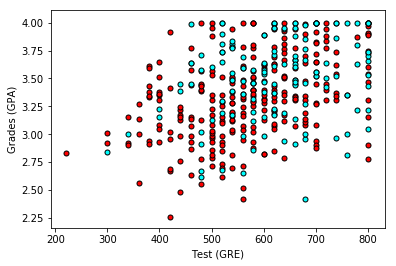

In [2]:
# Importing matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# Function to help us plot
def plot_points(data):
    X = np.array(data[["gre","gpa"]])
    y = np.array(data["admit"])
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'red', edgecolor = 'k')
    plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'cyan', edgecolor = 'k')
    plt.xlabel('Test (GRE)')
    plt.ylabel('Grades (GPA)')
    
# Plotting the points
plot_points(data)
plt.show()

粗略来说，它看起来像是，成绩 （grades) 和测试 (test) 分数高的学生通过了，而得分低的学生却没有，但数据并没有如我们所希望的那样，很好地分离。 也许将评级 (rank) 考虑进来会有帮助？ 接下来我们将绘制 4 个图，每个图代表一个级别。

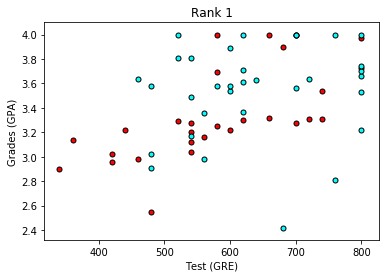

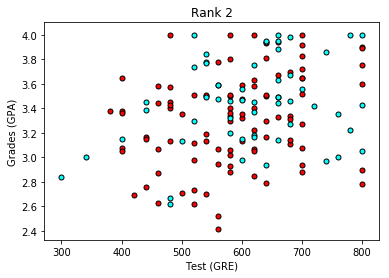

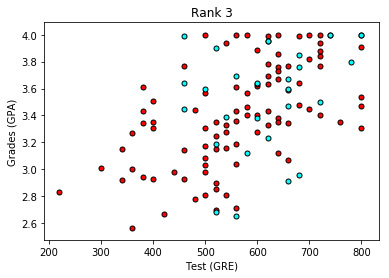

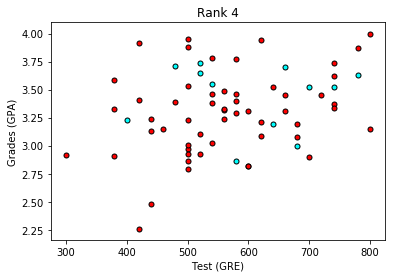

In [3]:
# Separating the ranks
data_rank1 = data[data["rank"]==1]
data_rank2 = data[data["rank"]==2]
data_rank3 = data[data["rank"]==3]
data_rank4 = data[data["rank"]==4]

# Plotting the graphs
plot_points(data_rank1)
plt.title("Rank 1")
plt.show()
plot_points(data_rank2)
plt.title("Rank 2")
plt.show()
plot_points(data_rank3)
plt.title("Rank 3")
plt.show()
plot_points(data_rank4)
plt.title("Rank 4")
plt.show()

现在看起来更棒啦，看上去评级越低，录取率越高。 让我们使用评级 (rank) 作为我们的输入之一。 为了做到这一点，我们应该对它进行一次one-hot 编码。

## 将评级进行 One-hot 编码
我们将在 Pandas 中使用 `get_dummies` 函数。

In [4]:
# TODO:  Make dummy variables for rank
one_hot_data = pd.concat([data, pd.get_dummies(data['rank'], prefix='rank')], axis=1)

# TODO: Drop the previous rank column
one_hot_data = one_hot_data.drop('rank', axis=1)

# Print the first 10 rows of our data
one_hot_data[:10]

admit  gre   gpa  rank_1  rank_2  rank_3  rank_4
0      0  380  3.61       0       0       1       0
1      1  660  3.67       0       0       1       0
2      1  800  4.00       1       0       0       0
3      1  640  3.19       0       0       0       1
4      0  520  2.93       0       0       0       1
5      1  760  3.00       0       1       0       0
6      1  560  2.98       1       0       0       0
7      0  400  3.08       0       1       0       0
8      1  540  3.39       0       0       1       0
9      0  700  3.92       0       1       0       0

## 缩放数据

下一步是缩放数据。 我们注意到成绩 (grades) 的范围是 1.0-4.0，而测试分数 （test scores) 的范围大概是 200-800，这个范围要大得多。 这意味着我们的数据存在偏差，使得神经网络很难处理。 让我们将两个特征放在 0-1 的范围内，将分数除以 4.0，将测试分数除以 800。

In [5]:
# Making a copy of our data
processed_data = one_hot_data[:]

# TODO: Scale the columns
processed_data['gre'] = processed_data['gre']/800
processed_data['gpa'] = processed_data['gpa']/800
# Printing the first 10 rows of our procesed data
processed_data[:10]

admit    gre       gpa  rank_1  rank_2  rank_3  rank_4
0      0  0.475  0.004513       0       0       1       0
1      1  0.825  0.004587       0       0       1       0
2      1  1.000  0.005000       1       0       0       0
3      1  0.800  0.003987       0       0       0       1
4      0  0.650  0.003663       0       0       0       1
5      1  0.950  0.003750       0       1       0       0
6      1  0.700  0.003725       1       0       0       0
7      0  0.500  0.003850       0       1       0       0
8      1  0.675  0.004237       0       0       1       0
9      0  0.875  0.004900       0       1       0       0

## 将数据分成训练集和测试集

为了测试我们的算法，我们将数据分为训练集和测试集。 测试集的大小将占总数据的 10％。

In [6]:
sample = np.random.choice(processed_data.index, size=int(len(processed_data)*0.9), replace=False)
train_data, test_data = processed_data.iloc[sample], processed_data.drop(sample)

print("Number of training samples is", len(train_data))
print("Number of testing samples is", len(test_data))
print(train_data[:10])
print(test_data[:10])

Number of training samples is 360
Number of testing samples is 40
     admit    gre       gpa  rank_1  rank_2  rank_3  rank_4
214      1  0.750  0.004450       0       1       0       0
379      0  0.675  0.003375       0       1       0       0
55       1  0.925  0.005000       0       0       1       0
195      0  0.700  0.004488       0       1       0       0
6        1  0.700  0.003725       1       0       0       0
115      0  0.775  0.004988       0       0       1       0
78       0  0.675  0.003900       1       0       0       0
175      1  0.775  0.004213       0       1       0       0
212      0  0.575  0.003587       0       1       0       0
60       1  0.775  0.003975       0       1       0       0
    admit    gre       gpa  rank_1  rank_2  rank_3  rank_4
10      0  1.000  0.005000       0       0       0       1
27      1  0.650  0.004675       0       0       0       1
41      1  0.725  0.004150       0       1       0       0
45      1  0.575  0.004313       0    

## 将数据分成特征和目标（标签）
现在，在培训前的最后一步，我们将把数据分为特征 (features)（X）和目标 (targets)（y）。

In [7]:
features = train_data.drop('admit', axis=1)
targets = train_data['admit']
features_test = test_data.drop('admit', axis=1)
targets_test = test_data['admit']

print(features[:10])
print(targets[:10])

       gre       gpa  rank_1  rank_2  rank_3  rank_4
214  0.750  0.004450       0       1       0       0
379  0.675  0.003375       0       1       0       0
55   0.925  0.005000       0       0       1       0
195  0.700  0.004488       0       1       0       0
6    0.700  0.003725       1       0       0       0
115  0.775  0.004988       0       0       1       0
78   0.675  0.003900       1       0       0       0
175  0.775  0.004213       0       1       0       0
212  0.575  0.003587       0       1       0       0
60   0.775  0.003975       0       1       0       0
214    1
379    0
55     1
195    0
6      1
115    0
78     0
175    1
212    0
60     1
Name: admit, dtype: int64


## 训练二层神经网络
下列函数会训练二层神经网络。 首先，我们将写一些 helper 函数。

In [8]:
# Activation (sigmoid) function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def sigmoid_prime(x):
    return sigmoid(x) * (1-sigmoid(x))
def error_formula(y, output):
    return - y * np.log(output) - (1-y) * np.log(1-output)

# 误差反向传播

现在轮到你来练习，编写误差项。 记住这是由方程 $$ (y-\hat{y})  $$ 给出的。

In [9]:
# TODO: Write the error term formula
def error_term_formula(y, output):
    return y * np.log(output) + (1-y) * np.log(1-output)

In [10]:
# Neural Network hyperparameters
epochs = 1000
learnrate = 0.5

# Training function
def train_nn(features, targets, epochs, learnrate):
    
    # Use to same seed to make debugging easier
    np.random.seed(42)

    n_records, n_features = features.shape
    last_loss = None

    # Initialize weights
    weights = np.random.normal(scale=1 / n_features**.5, size=n_features)

    for e in range(epochs):
        del_w = np.zeros(weights.shape)
        for x, y in zip(features.values, targets):
            # Loop through all records, x is the input, y is the target

            # Activation of the output unit
            #   Notice we multiply the inputs and the weights here 
            #   rather than storing h as a separate variable 
            output = sigmoid(np.dot(x, weights))

            # The error, the target minus the network output
            error = error_formula(y, output)

            # The error term
            #   Notice we calulate f'(h) here instead of defining a separate
            #   sigmoid_prime function. This just makes it faster because we
            #   can re-use the result of the sigmoid function stored in
            #   the output variable
            error_term = error_term_formula(y, output)

            # The gradient descent step, the error times the gradient times the inputs
            del_w += error_term * x

        # Update the weights here. The learning rate times the 
        # change in weights, divided by the number of records to average
        weights += learnrate * del_w / n_records

        # Printing out the error on the training set
        if e % (epochs / 10) == 0:
            out = sigmoid(np.dot(features, weights))
            loss = np.mean((out - targets) ** 2)
            print("Epoch:", e)
            if last_loss and last_loss < loss:
                print("Train loss: ", loss, "  WARNING - Loss Increasing")
            else:
                print("Train loss: ", loss)
            last_loss = loss
            print("=========")
    print("Finished training!")
    return weights
    
weights = train_nn(features, targets, epochs, learnrate)

Epoch: 0
Train loss:  0.251907724386


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in multiply
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 100
Train loss:  nan
Epoch: 200
Train loss:  nan
Epoch: 300
Train loss:  nan
Epoch: 400
Train loss:  nan
Epoch: 500
Train loss:  nan
Epoch: 600
Train loss:  nan
Epoch: 700
Train loss:  nan
Epoch: 800
Train loss:  nan
Epoch: 900
Train loss:  nan
Finished training!


## 计算测试 (Test) 数据的精确度

In [11]:
# Calculate accuracy on test data
tes_out = sigmoid(np.dot(features_test, weights))
predictions = tes_out > 0.5
accuracy = np.mean(predictions == targets_test)
print("Prediction accuracy: {:.3f}".format(accuracy))

Prediction accuracy: 0.725


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
